In [3]:
import glob
glob.glob("../data/*.csv")

['../data/export_dataframe.csv']

# Import libraries

In [1]:
import os
import pandas as pd
import re
import random
import numpy as np

from matplotlib import pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer

import pickle

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [2]:
file = "tweets2020.csv"
data = pd.read_csv(file)
data.head()

,Unnamed: 0,id_str,text,created_at,polarity,user_location
0,0,1333670422106304512,RT @bioethicsdotcom: Absolutely Remarkable: No...,2020-12-01 07:13:01,0,"Madrid, Spain"
1,1,1333670422135644162,RT @BTSFanQuiz: The fifth track of the BE albu...,2020-12-01 07:13:01,0,Albania
2,2,1333670422299152387,"RT @KailashChandOBE: Dear @RishiSunak ,\nCorre...",2020-12-01 07:13:01,0,"Ross-on-Wye, England"
3,3,1333670422508924928,RT @EmilyThornberry: Deeply moving report on P...,2020-12-01 07:13:01,0,NaN
4,4,1333670422529912833,RT @thebradfordfile: Even CNN is now admitting...,2020-12-01 07:13:01,0,NaN


In [3]:
len(data)

19363

We can see that multiple tweets have more than one classification and we can see many classfications in the toxic comments, however we only need to classify between toxic and non-toxic comments.

In [4]:
data.dtypes

Unnamed: 0        int64
id_str            int64
text             object
created_at       object
polarity          int64
user_location    object
dtype: object

# Preprocessing

All the special chars will be deleted.   
The regular expressions (RE_PATTERNS) are for the more common words which can be written in multiple ways for the toxic comments.

In [5]:
special_chars =r"[^a-z0-9!@#\$%\^\&\*_\-,\.' ]"
RE_PATTERNS = {
    ' fuck':['(f)([^a-z]*)(u)([^a-z]*)(c)([^a-z]*)(k)','(f)(u|[^a-z0-9 ])(c|[^a-z0-9 ])(k|[^a-z0-9 ])([^ ])*',
            'feck ', ' fux ', 'f\*\*', 'f\-ing', 'f u u c', '(f)(c|[^a-z ])(u|[^a-z ])(k)', r'f\*',' fu ',
            'f[!@#\$%\^\&\*]*u[!@#\$%\^&\*]*k', 'f\.u\.', 'f###', 'f@ck', 'f u c k', 'f uck', 'f ck' ],
    ' ass ':['[^a-z]ass ', '[^a-z]azz ', 'arrse', ' arse ', '@\$\$', '[^a-z]anus', ' a\*s\*s', 
        '[^a-z]ass[^a-z ]', 'a[@#\$%\^&\*][@#\$%\^&\*]', '[^a-z]anal ', 'a s s'],
    ' ass hole ':[' a[s|z]*wipe', 'a[s|z]*[w]*h[o|0]+[l]*e', '@\$\$hole'],
    ' bitch ':['(b)([^a-z]*)(i)([^a-z]*)(t)([^a-z]*)(c)([^a-z]*)(h)', 'b!tch','bi\+ch', 'b!\+ch',
               'b[w]*i[t]*ch','biatch', 'bi\*\*h', 'bytch', 'b i t c h'],
    ' bastard ':['ba[s|z]+t[e|a]+rd'],
    ' dick ':[' dick[^aeiou]', 'deek', 'd i c k'],
    ' suck ':[ 'sucker', '(s)([^a-z ]*)(u)([^a-z ]*)(c)([^a-z ]*)(k)', 'sucks', '5uck', 's u c k'],
    ' cunt ':['c u n t'],
    ' bull shit ':[ 'bullsh\*t', 'bull\$hit'],
    ' idiot ':['i[d]+io[t]+', '(i)([^a-z ]*)(d)([^a-z ]*)(i)([^a-z ]*)(o)([^a-z ]*)(t)','idiots','i d i o t'],
    ' cock ':['[^a-z]cock', 'c0ck', '[^a-z]cok ', 'c0k', '[^a-z]cok[^aeiou]', ' cawk',
            '(c)([^a-z ])(o)([^a-z ]*)(c)([^a-z ]*)(k)', 'c o c k'],
    ' dumb ':['(d)([^a-z ]*)(u)([^a-z ]*)(m)([^a-z ]*)(b)'],
    ' shit ':['shitty', '(s)([^a-z ]*)(h)([^a-z ]*)(i)([^a-z ]*)(t)', 'shite', '\$hit', 's h i t'],
    ' shit hole ':['shythole'],
    ' retard ':['returd', 'retad', 'retard', 'wiktard', 'wikitud'],
    ' rape ':['raped'],
    ' dumb ass':['dumbass', 'dubass'],
    ' ass head':['butthead'],
    ' nigger ':['nigger', 'ni[g]+a', ' nigr ', 'negrito', 'niguh', 'n3gr', 'n i g g e r'],
    ' shut the fuck up': ['stfu'],
    ' pussy ': ['pussy[^c]', 'pusy', 'pussi[^l]', 'pusses'],
    ' faggot ':['faggot', ' fa[g]+[s]*[^a-z ]', 'fagot', 'f a g g o t', 'faggit',
            '(f)([^a-z ]*)(a)([^a-z ]*)([g]+)([^a-z ]*)(o)([^a-z ]*)(t)', 'fau[g]+ot', 'fae[g]+ot',],
    ' mother fucker':[' motha ', ' motha f', ' mother f', 'motherucker'],
    ' whore ':['wh\*\*\*', 'w h o r e'],
    ' ':['h[\S]+//[\S]+', ' RT ']
}

In [6]:
class preprocessing(object):
    def __init__(self,special_chars, pattern):
        self.pattern = pattern
        self.special_chars = special_chars
    def cleanString(self,s):
        # remove special chars
        if self.special_chars is not None:
            s = re.sub(self.special_chars, ' ', s)
        #Delete users
        s= ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",s).split())
        s = s.replace("\\n", " ").replace("\n", " ")
        # Regular expressions
        pattern = re.compile(r"(.)\1{2,}", re.DOTALL)
        s = pattern.sub(r"\1", s)
        tokenizer = TweetTokenizer()
        # Remove stop words
        stop_words = set(stopwords.words('english'))
        cleaned_words = [w for w in tokenizer.tokenize(s) if w not in stop_words]
        return " ".join(cleaned_words)

    def stemWords(self,sentence):
        stemmer, tokenizer = PorterStemmer(), TweetTokenizer()
        stemmed_words = [stemmer.stem(w) for w in tokenizer.tokenize(sentence)]
        return " ".join(stemmed_words)

    def cleanFrame(selfdev,frame):
        frame['clean_comment'] = frame.text.apply(selfdev.cleanString)

    def stemFrame(selfdev,frame):
        frame['stem_comment'] = frame.clean_comment.apply(selfdev.stemWords)




In [9]:

Preprocessing=preprocessing(special_chars, RE_PATTERNS)
Preprocessing.cleanFrame(data)
Preprocessing.stemFrame(data)

The function cleanString hands with the special characters, regular expressions, stop words (for English).
The function stemWords stems the words already cleaned.
cleanFrame adds a new column "clean_comment", with the tweets already cleaned by applying the function cleanString
stemFrame got the new clean "clean_comment" from cleanFrame and apply in it stemWords, this is saved in a new column "stem_comment", this is the one which is going to be used for the classification.

In [10]:
data.head()


,Unnamed: 0,id_str,text,created_at,polarity,user_location,clean_comment,stem_comment
0,0,1333670422106304512,RT @bioethicsdotcom: Absolutely Remarkable: No...,2020-12-01 07:13:01,0,"Madrid, Spain",bsolutely emarkable ne ho ot odernas accine ri...,bsolut emark ne ho ot oderna accin rial evelop...
1,1,1333670422135644162,RT @BTSFanQuiz: The fifth track of the BE albu...,2020-12-01 07:13:01,0,Albania,uiz fifth track album inspired situation lockd...,uiz fifth track album inspir situat lockdown s...
2,2,1333670422299152387,"RT @KailashChandOBE: Dear @RishiSunak ,\nCorre...",2020-12-01 07:13:01,0,"Ross-on-Wye, England",ailash hand ear ishi unak orrect wrong ou spen...,ailash hand ear ishi unak orrect wrong ou spen...
3,3,1333670422508924928,RT @EmilyThornberry: Deeply moving report on P...,2020-12-01 07:13:01,0,NaN,mily hornberry eeply moving report overty ovid...,mili hornberri eepli move report overti ovid e...
4,4,1333670422529912833,RT @thebradfordfile: Even CNN is now admitting...,2020-12-01 07:13:01,0,NaN,ven admitting hina lied ovid cases deaths rump...,ven admit hina lie ovid case death rump right


# Save data in a pickle

In [11]:

pickle.dump(data, open('tweets2020.pickle','wb'))

# Load data

In [2]:
data = pickle.load(open('tweets2020.pickle','rb'))
data.head()

,Unnamed: 0,id_str,text,created_at,polarity,user_location,clean_comment,stem_comment
0,0,1333670422106304512,RT @bioethicsdotcom: Absolutely Remarkable: No...,2020-12-01 07:13:01,0,"Madrid, Spain",bsolutely emarkable ne ho ot odernas accine ri...,bsolut emark ne ho ot oderna accin rial evelop...
1,1,1333670422135644162,RT @BTSFanQuiz: The fifth track of the BE albu...,2020-12-01 07:13:01,0,Albania,uiz fifth track album inspired situation lockd...,uiz fifth track album inspir situat lockdown s...
2,2,1333670422299152387,"RT @KailashChandOBE: Dear @RishiSunak ,\nCorre...",2020-12-01 07:13:01,0,"Ross-on-Wye, England",ailash hand ear ishi unak orrect wrong ou spen...,ailash hand ear ishi unak orrect wrong ou spen...
3,3,1333670422508924928,RT @EmilyThornberry: Deeply moving report on P...,2020-12-01 07:13:01,0,NaN,mily hornberry eeply moving report overty ovid...,mili hornberri eepli move report overti ovid e...
4,4,1333670422529912833,RT @thebradfordfile: Even CNN is now admitting...,2020-12-01 07:13:01,0,NaN,ven admitting hina lied ovid cases deaths rump...,ven admit hina lie ovid case death rump right


# Vectorize

First we tokenize X_train and X_test

In [3]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(data.stem_comment))
list_tokenized = tokenizer.texts_to_sequences(data.stem_comment)

In [4]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized]
max(totalNumWords)

28

In [5]:
maxlen=400
V_data = pad_sequences(list_tokenized, maxlen=maxlen)
print(V_data.shape)

(19363, 400)


# Load the model

In [6]:
file_path="weights_classification.hdf5"

from keras.models import load_model
model = load_model(file_path)

c:\users\nickt\appdata\local\programs\python\python37\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


# Classification

In [7]:
from sklearn.pipeline import Pipeline

y_pred = model.predict(V_data)
y_pred.sum()/len(y_pred)

0.5936360685489077

In [18]:
y_pred

array([[0.96377015],
       [0.6385495 ],
       [0.9444725 ],
       ...,
       [0.6508758 ],
       [0.02491399],
       [0.6481593 ]], dtype=float32)

In [10]:
k=0
for i,v in enumerate(list(y_pred.round())):
    #i: index, v: values
    data.polarity[i]=v
    if v==1:
        print(y_pred[i], " Positive \n", data.text[i])
    else:
        k+=1
        print(y_pred[i]," Negative \n",data.text[i])

c:\users\nickt\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


[0.96377015]  Positive 
 RT @bioethicsdotcom: Absolutely Remarkable: No One Who Got Modernas Vaccine in Trial Developed Severe COVID-19 https://t.co/3QADpyduiQ
[0.6385495]  Positive 
 RT @BTSFanQuiz: The fifth track of the BE album  was inspired by their situation while in lockdown. The song created by Suga with retro-pop
[0.9444725]  Positive 
 RT @KailashChandOBE: Dear @RishiSunak ,
Correct me,if I am wrong! You have spent lot more money than comparative economies,to fight #COVID1
[0.09436972]  Negative 
 RT @EmilyThornberry: Deeply moving report on Poverty and Covid on the  @BBCNews at 10 tonight. They followed the work of Father Alex Frost
[0.9878561]  Positive 
 RT @thebradfordfile: Even CNN is now admitting China lied about Covid cases and deaths.

Trump was right--again.
[0.07225037]  Negative 
 RT @ImranKhanPTI: Problem confronting us in Pak during COVID 19 is of a political leadership that has never gone through any democratic str
[0.8067491]  Positive 
 RT @Catrambo: Just fou

There are   11546  positive comments and  7817  negative comments.


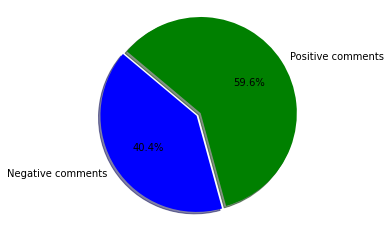

In [11]:
positive=data.polarity.sum()
negative=len(data)-positive
print("There are  ", positive, " positive comments and ", negative, " negative comments.")
labels = ['Negative comments', 'Positive comments']
sizes = [negative,positive]
colors = ['blue', 'green']
# Data to plot
explode = (0, 0.05)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

# Export file

Export the dataframe to csv with the polarities:   
    0 for negative   
    1 for positive

In [14]:
data.to_csv('tweets2020Classified.csv') 